In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import helper_400

%load_ext autoreload
%autoreload 2
helper_400.set_sns_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 800x600 with 0 Axes>

In [130]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [131]:
def get_svi():
    cols = [
        "STCNTY",
        "FIPS",
        "E_TOTPOP",
        "E_AFAM",
        "E_HISP",
        "E_ASIAN",
        "E_AIAN",
        "E_NHPI",
        "E_TWOMORE",
        "E_OTHERRACE",
    ]
    df = helper_400.get_svi_df(cols)
    df["E_WHITE"] = df["E_TOTPOP"] - df[
        ["E_AFAM", "E_HISP", "E_ASIAN", "E_AIAN", "E_NHPI", "E_TWOMORE", "E_OTHERRACE"]
    ].sum(axis=1)
    return df

# Exposure per FIPS over time

In [132]:
df = get_svi()

In [133]:
exposure = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")
exposure = exposure.groupby("GEOID").sum()
exposure = exposure.reset_index()

In [134]:
len(exposure[exposure["_hws"] != 0])

8673

In [135]:
df = df.merge(exposure, left_on="FIPS", right_on="GEOID")

In [136]:
hotspots = helper_400.hotspots

In [137]:
# normalize demographic variables by each groups' total population
demographic_cols = [
    "E_AFAM",
    "E_HISP",
    "E_ASIAN",
    "E_AIAN",
    "E_NHPI",
    "E_TWOMORE",
    "E_OTHERRACE",
    "E_WHITE",
    "E_TOTPOP",
]

for dc in demographic_cols:
    df[dc + "_normalized"] = df[dc] * 100 / df[dc].sum()

df = df.rename(
    columns={
        "E_WHITE_normalized": "white",
        "E_AFAM_normalized": "black",
        "E_HISP_normalized": "hispanic",
        "E_ASIAN_normalized": "asian",
        "E_AIAN_normalized": "indian or \nalaska native",
    }
)

cats = ["white", "black", "hispanic", "asian", "indian or \nalaska native"]

## Bar plots normalized per population

In [143]:
df.columns

Index(['STCNTY', 'FIPS', 'E_TOTPOP', 'E_AFAM', 'E_HISP', 'E_ASIAN', 'E_AIAN',
       'E_NHPI', 'E_TWOMORE', 'E_OTHERRACE', 'E_WHITE', 'GEOID', 'rhum',
       'wfday', 'heatday', 'coldday', 'polluted', 'smoke_pm_non_zero',
       'smoke_pm_gt_five', 'hw', 'hp', 'hwp', '_hws', 'hs', 'hws', 'ws', 'hs5',
       'hws5', 'ws5', 'heatday_2d', 'smoke_pm_non_zero_2d', 'wfday_2d',
       '_hws_2d', 'hs_2d', 'hws_2d', 'ws_2d', 'black', 'hispanic', 'asian',
       'indian or \nalaska native', 'E_NHPI_normalized',
       'E_TWOMORE_normalized', 'E_OTHERRACE_normalized', 'white',
       'E_TOTPOP_normalized', 'exposure_category'],
      dtype='object')

In [144]:
import plotting

hspts = plotting.get_hotspot_list()

In [145]:
hspts

['wfday',
 'heatday',
 'smoke_pm_non_zero',
 'smoke_pm_gt_five',
 'hw',
 '_hws',
 'hs',
 'hws',
 'ws',
 'hs5',
 'hws5',
 'ws5',
 'heatday_2d',
 'smoke_pm_non_zero_2d',
 'wfday_2d',
 '_hws_2d',
 'hs_2d',
 'hws_2d',
 'ws_2d']

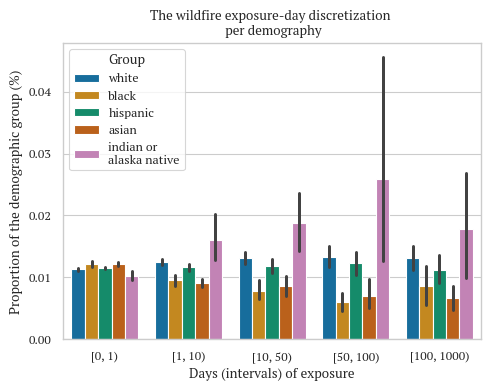

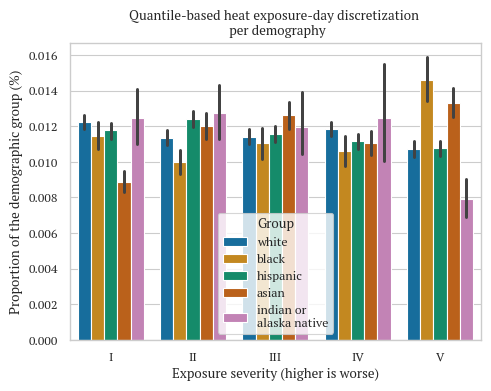

In [174]:
for hspt in hspts:
    df["exposure_category"] = helper_400.get_cut_vars(hspt, df[hspt])

    df_melt = pd.melt(
        df[cats + ["exposure_category"]],
        id_vars="exposure_category",
        var_name="type",
        value_name="value",
    )

    plt.figure(figsize=(5, 4))

    sns.barplot(
        data=df_melt,
        x="exposure_category",
        y="value",
        hue="type",
        errorbar="ci",
    )

    plt.title(helper_400.get_title(hspt))

    plt.ylabel("Proportion of the demographic group (%)")
    plt.xlabel("Exposure severity (higher is worse)")

    if hspt in [
        "wfday",
        "wfday_2d",
        "hw",
        "hws",
        "ws",
        "hws5",
        "ws5",
        "hws_2d",
        "ws_2d",
    ]:
        xlabel = "Days (intervals) of exposure"
        plt.xlabel(xlabel)

    plt.legend(title="Group", loc="best")
    plt.xticks(rotation=0)
    # ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig("figures/qbar_demographics" + "_" + hspt + ".png")
    plt.show()

## Obsolete

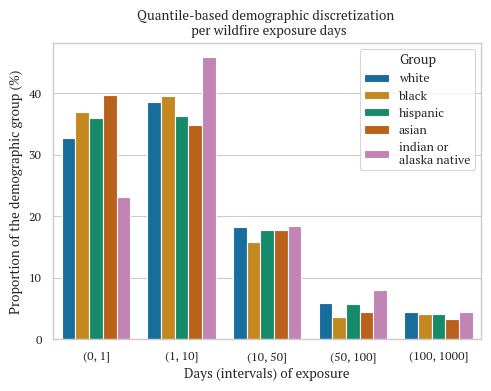

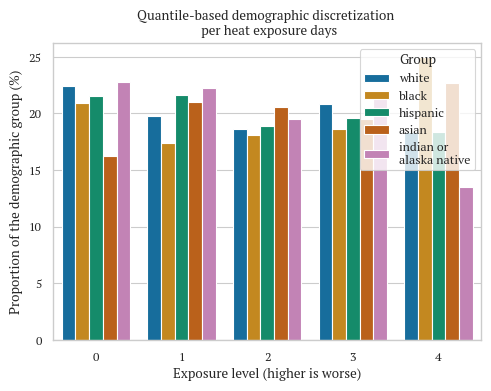

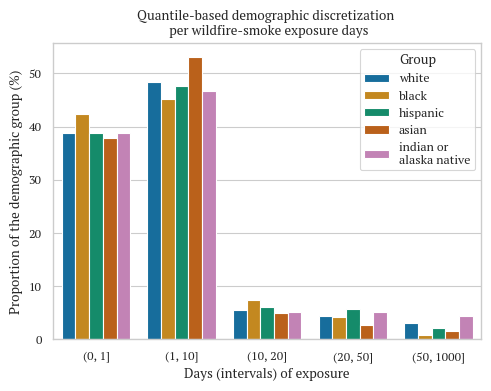

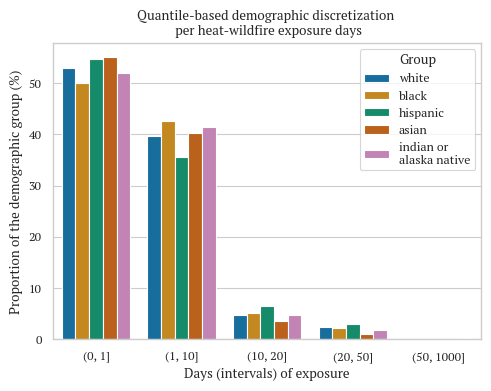

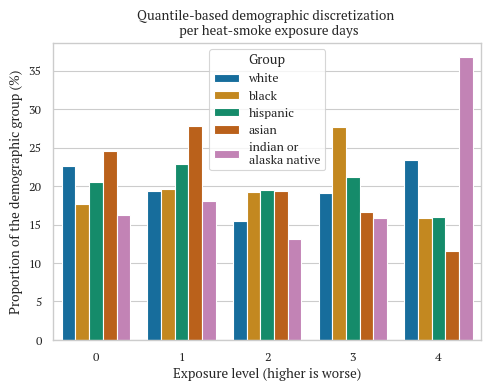

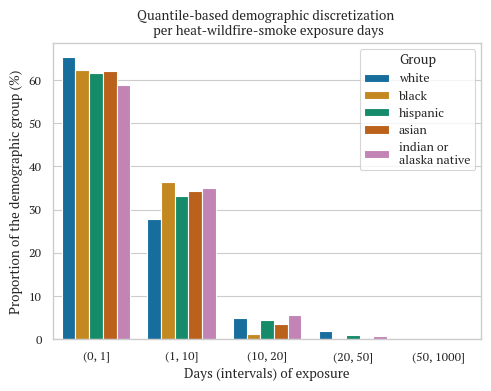

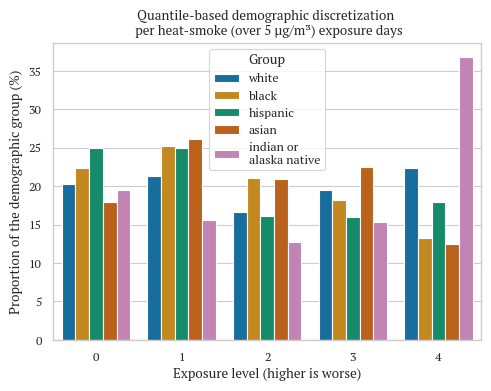

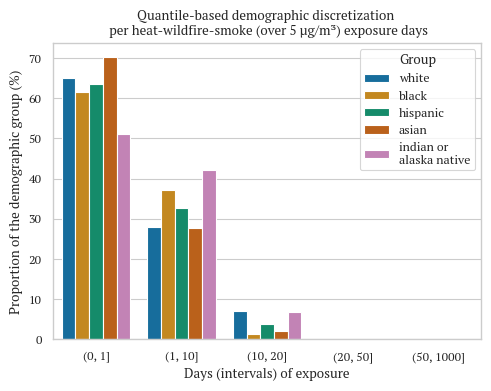

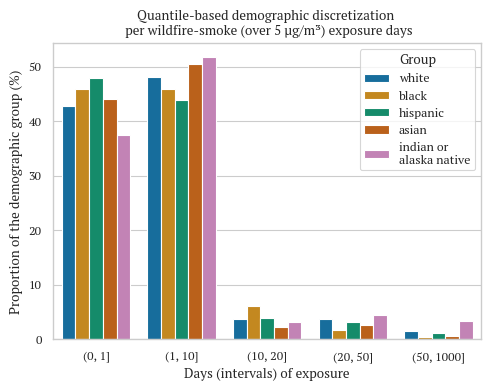

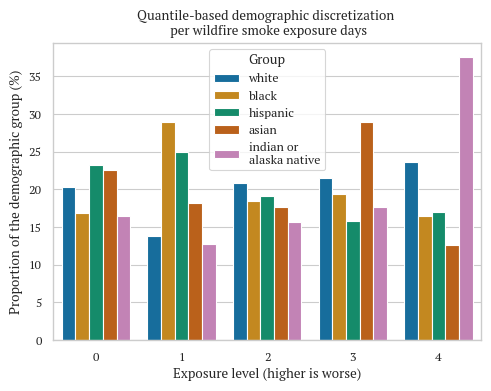

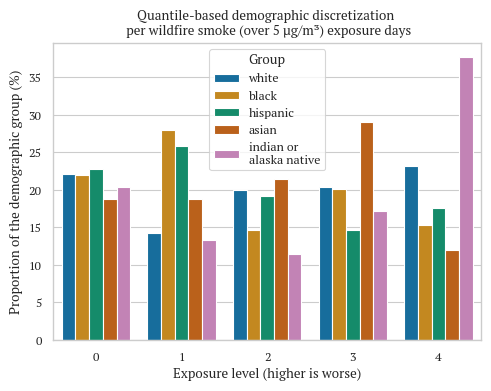

In [26]:
for hspt in hotspots.keys():
    df["exposure_category"] = helper_400.get_cut_vars(hspt, df[hspt])

    exposure_per_category = df.groupby("exposure_category")[demographic_cols].sum()

    for dc in demographic_cols:
        exposure_per_category[dc + "_normalized"] = (
            exposure_per_category[dc] * 100 / exposure_per_category[dc].sum()
        )

    exposure_per_category = exposure_per_category.drop(columns=demographic_cols)

    exposure_per_category = exposure_per_category.drop(
        columns=[
            "E_TOTPOP_normalized",
            "E_NHPI_normalized",
            "E_TWOMORE_normalized",
            "E_OTHERRACE_normalized",
        ]
    )

    exposure_per_category = exposure_per_category[
        [
            "E_WHITE_normalized",
            "E_AFAM_normalized",
            "E_HISP_normalized",
            "E_ASIAN_normalized",
            "E_AIAN_normalized",
        ]
    ]

    exposure_per_category = exposure_per_category.rename(
        columns={
            "E_WHITE_normalized": "white",
            "E_AFAM_normalized": "black",
            "E_HISP_normalized": "hispanic",
            "E_ASIAN_normalized": "asian",
            "E_AIAN_normalized": "indian or \nalaska native",
        }
    )

    helper_400.plot_qbar(exposure_per_category, hspt, figname="race", legloc="best")

In [170]:
# misc

df["exposure_category"] = helper_400.get_cut_vars("heatday", df["heatday"])

df_melt = pd.melt(
    df[cats + ["exposure_category"]],
    id_vars="exposure_category",
    var_name="type",
    value_name="sum_value",
)

df_melt["std"] = df_melt.groupby(["exposure_category", "type"]).transform("std")

df_agg = (
    df_melt.groupby(["exposure_category", "type"])[["sum_value", "std"]]
    .sum()
    .reset_index()
)
# Create separate bar plots for 'total_bill' and 'tip'
for value_type in cats:
    df_sub = df_agg[df_agg["type"] == value_type]
    plt.figure()
    sns.barplot(x="exposure_category", y="sum_value", data=df_sub, yerr=df_sub["std"])
    plt.title(f"Barplot for {value_type}")
    plt.show()